# Exploring Abstention Loss
author: Elizabeth A. Barnes, Randal J. Barnes
date: January 9, 2021, 1530MST

* based on Thulasidasan, S., T. Bhattacharya, J. Bilmes, G. Chennupati, and J. Mohd-Yusof, 2019: Combating Label Noise in Deep Learning Using Abstention. arXiv [stat.ML],.
* thesis: https://digital.lib.washington.edu/researchworks/handle/1773/45781
* code base is here: https://github.com/thulas/dac-label-noise/blob/master/dac_loss.py

In [4]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import random
# import xarray as xr
import scipy.stats as stats
import random
import time
import sys
from collections import Counter
import os.path
from os import path

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# import tensorflow as tf
# import tensorflow.keras as keras
# from keras.layers import Dense, Activation
# from keras import regularizers
# from keras import metrics
# from keras import optimizers
# # from keras.losses import Loss
# from keras.models import Sequential

import keras.backend as K
from keras.layers import Dense, Activation
from keras import regularizers
from keras import metrics
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
import tensorflow.keras as keras
import tensorflow as tf


import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import palettable
import pprint
import cartopy as ct
import cartopy.crs as ccrs


import metrics
import climatedata
import plots
import networkLRP as network
import experiments

import imp
imp.reload(experiments)
imp.reload(plots)

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
tf.print(f"sys.version = {sys.version}", output_stream=sys.stdout)
tf.print(f"tf.version.VERSION = {tf.version.VERSION}", output_stream=sys.stdout)

<tf.Operation 'PrintV2_1' type=PrintV2>

In [5]:
# DATA_NAME = 'badClasses0' #done
# DATA_NAME = 'badClasses1' # done
# DATA_NAME = 'mixedLabels2' #done
# DATA_NAME = 'mixedLabels3' # done
# DATA_NAME = 'tranquilFOO10' #done
# DATA_NAME = 'tranquilFOO12' # done
# DATA_NAME = 'tranquilFOO17' #done
# DATA_NAME = 'tranquilFOO18' # done
DATA_NAME = 'tranquilFOO20' # done


EXPINFO = experiments.define_experiments(DATA_NAME)
pprint.pprint(EXPINFO, width=60)

{'batch_size': 32,
 'cutoff': 0.5,
 'foo_region': 'nhENSO',
 'hiddens': [500, 250, 20],
 'loss': 'NotWrongLoss',
 'lr_init': 0.001,
 'nSamples': 42000,
 'np_seed': 99,
 'numClasses': 10,
 'nupd': 6,
 'prNoise': 0.5,
 'simple_data': '15x60',
 'spinup': 0,
 'undersample': False,
 'updater': 'Colorado'}


In [6]:
NP_SEED = 99
np.random.seed(NP_SEED)

In [7]:
def in_ipynb():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            mpl.use('Agg')            
            return False
    except:
        mpl.use('Agg')        
        return False
    return True

# Internal functions

In [8]:
def get_exp_name(loss, data_name, setpoint, NETWORK_SEED, extra_text = ''):
    # set experiment name
    if loss == 'DNN':
        EXP_NAME = (
            data_name
            + '_DNN'
            + '_prNoise' + str(PR_NOISE)
            + '_networkSeed' + str(NETWORK_SEED)
            + '_npSeed' + str(NP_SEED)
        )                
    else:
        EXP_NAME = (
            data_name
            + '_' + loss
            + '_' + UPDATER
            + '_abstSetpoint' + str(setpoint)
            + '_prNoise' + str(PR_NOISE)
            + '_networkSeed' + str(NETWORK_SEED)
            + '_npSeed' + str(NP_SEED)
    )

    return EXP_NAME + extra_text



In [9]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 400.

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([]) 

In [10]:
def get_frac_correct(y_true,y_pred):
    icorr = np.where(y_pred - y_true == 0)[0]
    if(len(y_true)==0):
        return 0., icorr
    else:
        return len(icorr)/len(y_true), icorr

def get_acc_stats(onehotlabels, y_pred, tranquil, abstain, dnn=False):
    
    cat_pred = np.argmax(y_pred,axis=-1)
    cat_true = np.argmax(onehotlabels,axis=-1)

    if(dnn is True):
        max_logits = np.max(y_pred,axis=-1)
        i_cover = np.where(max_logits >= np.percentile(max_logits, 100.*abstain))[0]
    else:
        i_cover = np.where(cat_pred != abstain)[0]        
    
    acc, j_corr = get_frac_correct(cat_true[i_cover],cat_pred[i_cover])
    n = len(i_cover)
    n_corr = len(j_corr)
    n_tr_corr = np.sum(tranquil[i_cover][j_corr])
    n_tr = np.sum(tranquil[i_cover])

    i_tr = np.where(tranquil[i_cover]==1)[0]
    acc_tr, __ = get_frac_correct(cat_true[i_cover][i_tr], cat_pred[i_cover][i_tr])

    i_tr = np.where(tranquil[i_cover]==0)[0]
    acc_ntr, __ = get_frac_correct(cat_true[i_cover][i_tr], cat_pred[i_cover][i_tr])

    return acc, acc_tr, acc_ntr, n, n_tr, n_tr_corr, n_corr

def corr_indices(onehotlabels, y_pred, abstain, dnn=False):
    
    cat_pred = np.argmax(y_pred,axis=-1)
    cat_true = np.argmax(onehotlabels,axis=-1)

    if(dnn is True):
        max_logits = np.max(y_pred,axis=-1)
        i_cover = np.where(max_logits >= np.percentile(max_logits, 100.*abstain))[0]
    else:
        i_cover = np.where(cat_pred != abstain)[0]        
        
    acc, j_corr = get_frac_correct(cat_true[i_cover],cat_pred[i_cover])

    return i_cover[j_corr], acc


# Load the data

In [11]:
# load the data
if 'SSTrand' not in globals():
    try:
        SIMPLE_DATA = EXPINFO['simple_data']
    except KeyError:
        SIMPLE_DATA = False

    try:
        REGION_NAME = EXPINFO['foo_region']
    except KeyError:
        REGION_NAME = 'ENSO'
        
    if(SIMPLE_DATA==True):
        SSTrand, y, lat, lon = climatedata.load_simpledata(size='15x60')
    elif(SIMPLE_DATA==False):
        SSTrand, y, lat, lon = climatedata.load_data()
    else:
        SSTrand, y, lat, lon = climatedata.load_simpledata(size=SIMPLE_DATA)

lat = np.squeeze(lat)
lon = np.squeeze(lon)
print('SST shape = ' + str(np.shape(SSTrand)))


SST shape = (50000, 15, 60)


In [12]:
imp.reload(climatedata)
np.random.seed(NP_SEED)

NLABEL = EXPINFO['numClasses']
NSAMPLES = EXPINFO['nSamples']
PR_NOISE = EXPINFO['prNoise']
CUTOFF = EXPINFO['cutoff']
UNDERSAMPLE = EXPINFO['undersample']

#----------------------------
# get training data
X, y_cat, tranquil, corrupt, y_perc = climatedata.add_noise(data_name=DATA_NAME, 
                                                   X=SSTrand[:NSAMPLES], 
                                                   y=y[:NSAMPLES], 
                                                   lat=lat, 
                                                   lon=lon, 
                                                   pr_noise=PR_NOISE, 
                                                   nlabel=NLABEL, 
                                                   cutoff=CUTOFF,
                                                   region_name=REGION_NAME,                                                            
                                                  )
data_train, data_val, data_test = climatedata.split_data(X, y_cat, tranquil, corrupt)
X_train, y_train, tr_train, cr_train = data_train
X_test, y_test, tr_test, cr_test = data_test

#----------------------------
# undersample the data
if UNDERSAMPLE:
    print('----Training----')
    X_train, y_train, tr_train = climatedata.undersample(X_train, y_train, tr_train) # training data
    print('total samples = ' + str(np.shape(X_train)[0]))    
    print('----Testing----')
    X_test, y_test, tr_test = climatedata.undersample(X_test, y_test, tr_test) # testing data
    print('total samples = ' + str(np.shape(X_test)[0]))            
    
# process data for training
X_train_std, onehotlabels, X_test_std, onehotlabels_test, xmean, xstd = climatedata.preprocess_data(X_train, y_train, X_test, y_test, NLABEL)


region shape = 1 x 15

----Mislabeled----
# tranquil = 12259 out of 42000 samples
percent tranquil = 29.0%
tranquil mislabeled = 0.0%
non-tranquil mislabeled = 50.0%
total mislabeled = 35.0%
----Training----
(32000, 15, 60)
(32000, 1)
(32000,)
----Validation----
(5000, 15, 60)
(5000, 1)
(5000,)
----Testing----
(5000, 15, 60)
(5000, 1)
(5000,)


In [13]:
import scipy.io as sio
data_filename = '../data/synthClimate/simple_climatedata_' + SIMPLE_DATA + '.mat'    
mat_contents = sio.loadmat(data_filename)
    
Cnt = np.array(mat_contents['Cnt'])
np.shape(Cnt)

n_test = 5000
n_val = 5000
n_train = NSAMPLES - n_val - n_test
Cnt = Cnt[n_train+n_val:n_train+n_val*2,:,:]
Cnt = np.abs(Cnt)
Cnt = np.nan_to_num(Cnt, copy=False, nan=0.0)
print(np.shape(Cnt))

(5000, 15, 60)


# Plot the results

In [14]:
imp.reload(metrics)
LOSS = EXPINFO['loss']
UPDATER = EXPINFO['updater']
REWRITE = False
EXTRA_TEXT = ''
#---------------------
# Set parameters
hiddens = EXPINFO['hiddens']
SPINUP_EPOCHS = EXPINFO['spinup']
BATCH_SIZE = EXPINFO['batch_size']
N_EPOCHS = 200
lr_epoch_bound = 10000
RIDGE = 0.
DNN_EPOCHS = 999
DAC_EPOCHS = 999
#---------------------
DNN_model = network.defineNN(hiddens, 
                             input_shape=X_train_std.shape[1], 
                             output_shape=NLABEL, 
                             ridge_penalty=RIDGE, 
                             act_fun='relu', 
                             network_seed=99)
DAC_model = network.defineNN(hiddens, 
                             input_shape=X_train_std.shape[1], 
                             output_shape=NLABEL+1, 
                             ridge_penalty=RIDGE, 
                             act_fun='relu', 
                             network_seed=99)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



## Compare all stats

In [15]:
def lrp_loop(app, seed_vector, setpoint_list):
    
    approach_dic = {
                'DNN':'', 
                'DAC':'', 
                'ORACLE':'_oracle', 
               }

    lrp_corr = 0
    lrp_tr = 0
    lrp_tr_corr = 0
    cnt_tr = 0
    cnt_tr_corr = 0
    network_count = 0
    coverage_vec = []

    for NETWORK_SEED in seed_vector:      
        setpoint = setpoint_list[NETWORK_SEED]
        
        #-------------------
        # get model names
        if(app=='DNN' or app=='ORACLE' or app=='SELENE'):
            EXP_NAME = get_exp_name(loss = 'DNN', data_name=DATA_NAME, setpoint=setpoint,NETWORK_SEED=NETWORK_SEED,extra_text=approach_dic[app])
        elif(app=='DAC'):
            EXP_NAME = get_exp_name(loss = LOSS, data_name=DATA_NAME, setpoint=setpoint,NETWORK_SEED=NETWORK_SEED,extra_text = approach_dic[app])
        elif(app=='DNN-DNN' or app=='DAC-DNN'):
            EXP_NAME = get_exp_name(loss = 'DNN', data_name=DATA_NAME, setpoint=setpoint,NETWORK_SEED=NETWORK_SEED,extra_text=approach_dic[app])
            i = EXP_NAME.find('prNoise')
            EXP_NAME = EXP_NAME[:i] + 'abstSetpoint' + str(setpoint) + '_' + EXP_NAME[i:]
        else:
            raise ValueError('no such approach')
        model_file = 'saved_models/model_' +  EXP_NAME + '.h5'

        #check for the model file, skip if it does not exist
        if(os.path.exists(model_file)==False):
            continue
        print('network seed ' + str(NETWORK_SEED) + ' of ' + str(seed_vector[-1]))
        print('setpoint = ' + str(setpoint))

        if(app=='DAC'):
            DAC_model.load_weights(model_file)
            model_nosoftmax = innvestigate.utils.model_wo_softmax(DAC_model)                                
            y_pred = DAC_model.predict(X_test_std)
            i_corr, acc = corr_indices(onehotlabels=onehotlabels_test,
                                       y_pred=y_pred,
                                       abstain=NLABEL,
                                       dnn=False)
            print('acc = ' + str(acc))                
            acc, acc_tr, acc_ntr, n_cover, n_tr, n_tr_corr, n_corr = get_acc_stats(onehotlabels=onehotlabels_test, 
                                                                y_pred=y_pred, 
                                                                tranquil=tr_test, 
                                                                abstain=NLABEL,
                                                                dnn=False)      
            print('coverage = ' + str(np.around(100*n_cover/len(y_pred),2)))
            coverage_vec.append(np.around(100*n_cover/len(y_pred),2))
        else:  
            DNN_model.load_weights(model_file)
            model_nosoftmax = innvestigate.utils.model_wo_softmax(DNN_model)                
            y_pred = DNN_model.predict(X_test_std) 
            i_corr, acc = corr_indices(onehotlabels=onehotlabels_test,
                                       y_pred=y_pred,
                                       abstain=setpoint,
                                       dnn=True)
            print('acc = ' + str(acc))                
            print('coverage = ' + str(np.around(100*(1.-setpoint),2)))
            coverage_vec.append(np.around(100*(1.-setpoint),2))


        #=======================================================
        # compute LRP-Z (bias included)
        analyzer = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZ(model_nosoftmax)
        lrp_output = analyzer.analyze(X_test_std)
        
        # norm with the sum of the positive contributions
        lrp_output_norm = np.copy(lrp_output)
        lrp_output_norm[lrp_output_norm<=0.] = 0.
        norm = np.sum(lrp_output_norm,axis=-1)
        
        # keep negative and positive contributions when taking the average
        # just have the norm be over the positive values only
        lrp_output = lrp_output/norm[:,np.newaxis]

        #=======================================================
        # make composites on correct and tranquil
        lrp_corr = lrp_corr + np.mean(lrp_output[i_corr],axis=0)

        i_tr = np.where(tr_test==1)[0]
        lrp_tr = lrp_tr + np.mean(lrp_output[i_tr],axis=0)
        
        i_tr_corr = np.intersect1d(i_tr,i_corr)
        lrp_tr_corr = lrp_tr_corr + np.mean(lrp_output[i_tr_corr],axis=0)

        norm = np.sum(np.sum(Cnt,axis=2),axis=1)
        cont = Cnt/norm[:,np.newaxis,np.newaxis]
        cnt_tr = cnt_tr + np.mean(cont[i_tr],axis=0)
        cnt_tr_corr = cnt_tr_corr + np.mean(cont[i_tr_corr],axis=0)

        network_count = network_count + 1
        print('-----')

    return lrp_corr/network_count, lrp_tr/network_count, lrp_tr_corr/network_count, cnt_tr/network_count, cnt_tr_corr/network_count, np.asarray(coverage_vec)


In [23]:
mapProj = ct.crs.EqualEarth(central_longitude = 0.)
def plot_lrp_panel(ax,lrp,lat,lon,cbar_max=0.004):
    inc = cbar_max/2.
    cbar_ticks = np.arange(-cbar_max,cbar_max+inc,inc)
    cmap = palettable.colorbrewer.diverging.RdBu_5_r.mpl_colormap

    cb, image = plots.drawOnGlobe(ax, 
                            mapProj,
                            lrp.reshape((len(lat),len(lon))), 
                            lat, 
                            lon, 
                            cmap = cmap, 
                            vmin=-cbar_max, 
                            vmax=cbar_max, 
                            cbarBool=True, 
                            fastBool=False, 
                            extent='both'
                           )
    reg_lats, reg_lons = climatedata.get_region(region_name = REGION_NAME)    
    plt.plot([reg_lons[0], reg_lons[0],reg_lons[1],reg_lons[1],reg_lons[0]], [reg_lats[0], reg_lats[1], reg_lats[1], reg_lats[0],reg_lats[0]],
             color='white', linestyle='--',
             transform=ccrs.PlateCarree(),
             )
    cb.set_ticks(cbar_ticks)     
    
    return cb

    
def plot_lrp_summary(lrp_tr_DNN, lrp_tr_DAC, lrp_tr_corr_DNN, lrp_tr_corr_DAC, cnt_DNN, cnt_DAC, lat, lon):

    # make the plot
    plt.figure(figsize=(18*1.,2.73*3*1.5))

    #-----------------------------------------------    
    app = 'DNN'
    # subplot 1
    ax1 = plt.subplot(3,3,1,projection=mapProj)
    cb = plot_lrp_panel(ax1,lrp_tr_DNN,lat,lon)
    plt.title(app + ' tranquil')

    # subplot 2
    ax2 = plt.subplot(3,3,2,projection=mapProj)
    cb = plot_lrp_panel(ax2,lrp_tr_corr_DNN,lat,lon)    
    plt.title(app + ' tranquil and correct')
    
    # subplot 3
    ax3 = plt.subplot(3,3,3,projection=mapProj)
    cb = plot_lrp_panel(ax3,cnt_DNN,lat,lon,cbar_max=.004)   
    plt.title('absolute contributions\n' + app + ' tranquil')
    
    #-----------------------------------------------
    app = 'DAC'
    # subplot 4
    ax4 = plt.subplot(3,3,4,projection=mapProj)
    cb = plot_lrp_panel(ax4,lrp_tr_DAC,lat,lon)
    plt.title(app + ' tranquil')    

    # subplot 5
    ax5 = plt.subplot(3,3,5,projection=mapProj)
    cb = plot_lrp_panel(ax5,lrp_tr_corr_DAC,lat,lon)    
    plt.title(app + ' tranquil and correct')    

    # subplot 6
    ax6 = plt.subplot(3,3,6,projection=mapProj)
    cb = plot_lrp_panel(ax6,cnt_DAC,lat,lon,cbar_max=.004)   
    plt.title('absolute contributions\n' + app + ' tranquil')
    
    #-----------------------------------------------
    app = 'Difference: '
    # subplot 7
    ax4 = plt.subplot(3,3,7,projection=mapProj)
    cb = plot_lrp_panel(ax4,lrp_tr_DAC-lrp_tr_DNN,lat,lon,cbar_max=.001)   
    plt.title(app + ' tranquil')      

    # subplot 8
    ax5 = plt.subplot(3,3,8,projection=mapProj)
    cb = plot_lrp_panel(ax5,lrp_tr_corr_DAC-lrp_tr_corr_DNN,lat,lon,cbar_max=.001)    
    plt.title(app + ' tranquil and correct')        

    # subplot 9
    ax6 = plt.subplot(3,3,9,projection=mapProj)
    cb = plot_lrp_panel(ax6,cnt_DAC-cnt_DNN,lat,lon,cbar_max=.001)    
    plt.title(app + ' tranquil absolute contributions')        
        
    # #-----------------------------
    plt.tight_layout()
    

In [14]:
raise ValueError('here')

ValueError: here

## Computation and plots comparing DNN to DAC

In [ ]:
seed_vector = np.arange(0,23)

for setpoint_DAC in (.7,.1):#(.1,.2,.5,.7):
    setpoint_list = setpoint_DAC*np.ones(np.shape(seed_vector))

    app = 'DAC'
    print('======\n' + app + '\n======')
    lrp_corr_DAC, lrp_tr_DAC, lrp_tr_corr_DAC, cnt_tr_DAC,cnt_tr_corr_DAC, coverage_vec_DAC = lrp_loop(app=app, seed_vector=seed_vector, setpoint_list=setpoint_list)

    app = 'DNN'
    print('======\n' + app + '\n======')
    lrp_corr_DNN, lrp_tr_DNN, lrp_tr_corr_DNN, cnt_tr_DNN, cnt_tr_corr_DNN, coverage_vec_DNN = lrp_loop(app=app, seed_vector=seed_vector, setpoint_list=1.-coverage_vec_DAC/100.)

    #--------------------------
    # create the plot
    plot_lrp_summary(lrp_tr_DNN, lrp_tr_DAC, lrp_tr_corr_DNN, lrp_tr_corr_DAC, cnt_tr_DNN, cnt_tr_DAC, lat, lon)
    plt.savefig('figures/examples/' 
                + 'lrp_'
                + DATA_NAME
                + '_setpoint' + str(setpoint_DAC)
                +'.png',dpi=dpiFig)  
    plt.close()

In [ ]:
raise ValueError('here')

# LRP for why abstaining

In [19]:
mapProj = ct.crs.EqualEarth(central_longitude = 180.)
def plot_lrp_panel_paper(ax,lrp,lat,lon,cbar_max=0.006):
    inc = cbar_max/4.
    cbar_ticks = np.arange(-cbar_max,cbar_max+inc,inc)
#     cmap = palettable.colorbrewer.sequential.PuRd_9.mpl_colormap
#     cmap = palettable.cmocean.sequential.Amp_20.mpl_colormap
    cmap = 'Reds'

    cb, image = plots.drawOnGlobe(ax, 
                            mapProj,
                            lrp.reshape((len(lat),len(lon))), 
                            lat, 
                            lon, 
                            cmap = cmap, 
                            vmin=0, 
                            vmax=cbar_max, 
                            cbarBool=True, 
                            fastBool=False, 
                            extent='max'
                           )
    reg_lats, reg_lons = climatedata.get_region(region_name = REGION_NAME)    
    plt.plot([reg_lons[0], reg_lons[0],reg_lons[1],reg_lons[1],reg_lons[0]], [reg_lats[0], reg_lats[1], reg_lats[1], reg_lats[0],reg_lats[0]],
             color='white', linestyle='--',
             transform=ccrs.PlateCarree(),
             )
    cb.set_ticks(cbar_ticks)     
    
    return cb

mapProj = ct.crs.EqualEarth(central_longitude = 180.)

def plot_lrp_panel_paper_diff(ax,lrp,lat,lon,cbar_max=0.006):
    inc = cbar_max/4.
    cbar_ticks = np.arange(-cbar_max,cbar_max+inc,inc)
#     cmap = palettable.colorbrewer.sequential.PuRd_9.mpl_colormap
#     cmap = palettable.cmocean.sequential.Amp_20.mpl_colormap
#     cmap = 'Reds'
    cmap = palettable.colorbrewer.diverging.RdBu_5_r.mpl_colormap
    cb, image = plots.drawOnGlobe(ax, 
                            mapProj,
                            lrp.reshape((len(lat),len(lon))), 
                            lat, 
                            lon, 
                            cmap = cmap, 
                            vmin=-cbar_max, 
                            vmax=cbar_max, 
                            cbarBool=True, 
                            fastBool=False, 
                            extent='max'
                           )
    reg_lats, reg_lons = climatedata.get_region(region_name = REGION_NAME)    
    plt.plot([reg_lons[0], reg_lons[0],reg_lons[1],reg_lons[1],reg_lons[0]], [reg_lats[0], reg_lats[1], reg_lats[1], reg_lats[0],reg_lats[0]],
             color='white', linestyle='--',
             transform=ccrs.PlateCarree(),
             )
    cb.set_ticks(cbar_ticks)     
    
    return cb

In [20]:
def lrp_loop_abstain(app, seed_vector, setpoint_list):
    
    approach_dic = {
                'DNN':'', 
                'DAC':'', 
                'ORACLE':'_oracle', 
               }

    lrp_corr = 0
    lrp_abstain = 0    
    lrp_tr = 0
    lrp_tr_corr = 0
    cnt_tr = 0
    cnt_tr_corr = 0
    network_count = 0
    coverage_vec = []

    for NETWORK_SEED in seed_vector:      
        setpoint = setpoint_list[NETWORK_SEED]
        
        #-------------------
        # get model names
        if(app=='DNN' or app=='ORACLE' or app=='SELENE'):
            EXP_NAME = get_exp_name(loss = 'DNN', data_name=DATA_NAME, setpoint=setpoint,NETWORK_SEED=NETWORK_SEED,extra_text=approach_dic[app])
        elif(app=='DAC'):
            EXP_NAME = get_exp_name(loss = LOSS, data_name=DATA_NAME, setpoint=setpoint,NETWORK_SEED=NETWORK_SEED,extra_text = approach_dic[app])
        elif(app=='DNN-DNN' or app=='DAC-DNN'):
            EXP_NAME = get_exp_name(loss = 'DNN', data_name=DATA_NAME, setpoint=setpoint,NETWORK_SEED=NETWORK_SEED,extra_text=approach_dic[app])
            i = EXP_NAME.find('prNoise')
            EXP_NAME = EXP_NAME[:i] + 'abstSetpoint' + str(setpoint) + '_' + EXP_NAME[i:]
        else:
            raise ValueError('no such approach')
        model_file = 'saved_models/model_' +  EXP_NAME + '.h5'

        #check for the model file, skip if it does not exist
        if(os.path.exists(model_file)==False):
            continue
        print('network seed ' + str(NETWORK_SEED) + ' of ' + str(seed_vector[-1]))
        print('setpoint = ' + str(setpoint))

        if(app=='DAC'):
            DAC_model.load_weights(model_file)
            model_nosoftmax = innvestigate.utils.model_wo_softmax(DAC_model)                                
            y_pred = DAC_model.predict(X_test_std)
            i_corr, acc = corr_indices(onehotlabels=onehotlabels_test,
                                       y_pred=y_pred,
                                       abstain=NLABEL,
                                       dnn=False)
            i_abstain = np.where(np.argmax(y_pred,axis=1)==NLABEL)[0]
            print('acc = ' + str(acc))                
#             plt.hist(np.argmax(onehotlabels_test[i_corr],axis=1))
#             plt.show()
            corr_labels = np.argmax(onehotlabels_test[i_corr],axis=1)
            i_corr = i_corr[corr_labels==0]
            print('**** grabbing correct samples for label = 0 ****')
            
            acc, acc_tr, acc_ntr, n_cover, n_tr, n_tr_corr, n_corr = get_acc_stats(onehotlabels=onehotlabels_test, 
                                                                y_pred=y_pred, 
                                                                tranquil=tr_test, 
                                                                abstain=NLABEL,
                                                                dnn=False)      
            print('coverage = ' + str(np.around(100*n_cover/len(y_pred),2)))
            coverage_vec.append(np.around(100*n_cover/len(y_pred),2))
        else:  
            DNN_model.load_weights(model_file)
            model_nosoftmax = innvestigate.utils.model_wo_softmax(DNN_model)                
            y_pred = DNN_model.predict(X_test_std) 
            i_corr, acc = corr_indices(onehotlabels=onehotlabels_test,
                                       y_pred=y_pred,
                                       abstain=setpoint,
                                       dnn=True)
            print('acc = ' + str(acc))                
            print('coverage = ' + str(np.around(100*(1.-setpoint),2)))
            coverage_vec.append(np.around(100*(1.-setpoint),2))
            
            i_abstain = []
            corr_labels = np.argmax(onehotlabels_test[i_corr],axis=1)            
            i_corr = i_corr[corr_labels==0]
            print('**** grabbing correct samples for label = 0 ****')
            
            


        #=======================================================
        # compute LRP-Z (bias included)
        analyzer = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZ(model_nosoftmax)
        lrp_output = analyzer.analyze(X_test_std)
        
        # make negative contributions equal to zero
        lrp_output[lrp_output<0] = 0.
        
        # norm with the sum of the positive contributions
        lrp_output_norm = np.copy(lrp_output)
        lrp_output_norm[lrp_output_norm<=0.] = 0.
        norm = np.sum(lrp_output_norm,axis=-1)
        
        # keep negative and positive contributions when taking the average
        # just have the norm be over the positive values only
        lrp_output = lrp_output/norm[:,np.newaxis]

        #=======================================================
        # make composites on abstained
        lrp_corr = lrp_corr + np.mean(lrp_output[i_corr],axis=0)
        lrp_abstain = lrp_abstain + np.mean(lrp_output[i_abstain],axis=0)        

        i_tr = np.where(tr_test==1)[0]
        lrp_tr = lrp_tr + np.mean(lrp_output[i_tr],axis=0)
        
        i_tr_corr = np.intersect1d(i_tr,i_corr)
        lrp_tr_corr = lrp_tr_corr + np.mean(lrp_output[i_tr_corr],axis=0)

        norm = np.sum(np.sum(Cnt,axis=2),axis=1)
        cont = Cnt/norm[:,np.newaxis,np.newaxis]
        cnt_tr = cnt_tr + np.mean(cont[i_tr],axis=0)
        cnt_tr_corr = cnt_tr_corr + np.mean(cont[i_tr_corr],axis=0)

        network_count = network_count + 1
        print('-----')

    return lrp_corr/network_count, lrp_abstain/network_count, lrp_tr/network_count, lrp_tr_corr/network_count, cnt_tr/network_count, cnt_tr_corr/network_count, np.asarray(coverage_vec)


In [ ]:
seed_vector = np.arange(0,50)

for setpoint_DAC in (.7,):
    setpoint_list = setpoint_DAC*np.ones(np.shape(seed_vector))

    app = 'DAC'
    print('======\n' + app + '\n======')
    lrp_corr_DAC, lrp_abstain_DAC, lrp_tr_DAC, lrp_tr_corr_DAC, cnt_tr_DAC,cnt_tr_corr_DAC, coverage_vec_DAC = lrp_loop_abstain(app=app, seed_vector=seed_vector, setpoint_list=setpoint_list)


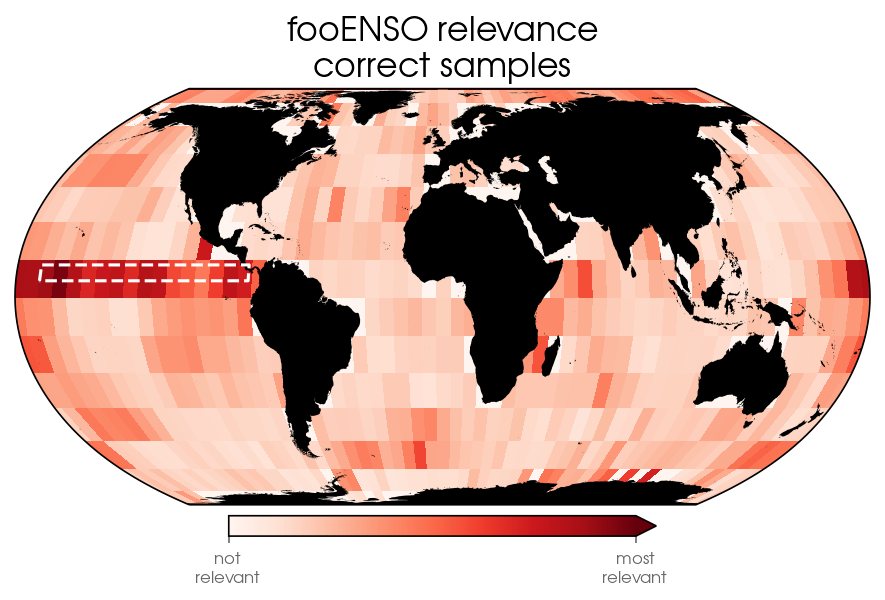

In [24]:
# lrp_corr_DAC, lrp_abstain_DAC, lrp_tr_DAC, lrp_tr_corr_DAC, cnt_tr_DAC,cnt_tr_corr_DAC, coverage_vec_DAC = lrp_loop_abstain(app=app, seed_vector=seed_vector, setpoint_list=setpoint_list)
# make the plot
plt.figure(figsize=(6*1.,2.73*1.5))

#-----------------------------------------------    
cbar_max=0.0045

ax2 = plt.subplot(1,1,1,projection=mapProj)
cb = plot_lrp_panel_paper(ax2,lrp_corr_DAC,lat,lon,cbar_max=cbar_max)
plt.title('fooENSO relevance\ncorrect samples',fontsize=16)
cb.set_ticks((0,cbar_max))
cb.set_ticklabels(('not\nrelevant','most\nrelevant'))
cb.ax.tick_params(labelsize=8)

plt.tight_layout()
# plt.savefig('figures/paper_plots/' 
#             + '/lrp_' + DATA_NAME 
#             +'.png',dpi=dpiFig)  

plt.show()


# Make new architecture map

[   0    5    7 ... 4984 4988 4989]
y_cateory = [8.]


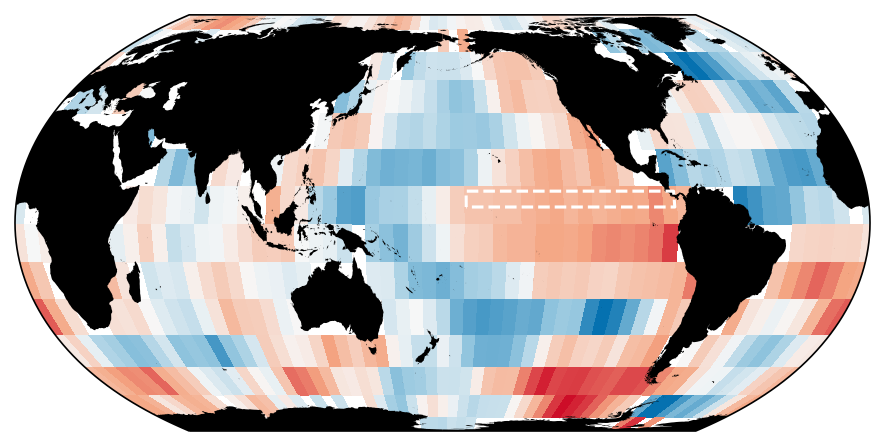

In [98]:
# lrp_corr_DAC, lrp_abstain_DAC, lrp_tr_DAC, lrp_tr_corr_DAC, cnt_tr_DAC,cnt_tr_corr_DAC, coverage_vec_DAC = lrp_loop_abstain(app=app, seed_vector=seed_vector, setpoint_list=setpoint_list)
# make the plot
plt.figure(figsize=(6*1.,2.73*1.5))

i = np.where(tr_test==1)[0]
print(i)

isample = i[1]
xplot = X_test[isample,:]
print('y_cateory = ' + str(y_test[isample]))
#-----------------------------------------------    
cbar_max=3.

ax = plt.subplot(1,1,1,projection=mapProj)
cmap = palettable.colorbrewer.diverging.RdBu_5_r.mpl_colormap
cb, image = plots.drawOnGlobe(ax, 
                        mapProj,
                        xplot.reshape((len(lat),len(lon))), 
                        lat, 
                        lon, 
                        cmap = cmap, 
                        vmin=-cbar_max, 
                        vmax=cbar_max, 
                        cbarBool=False, 
                        fastBool=False, 
                        extent='max'
                       )
reg_lats, reg_lons = climatedata.get_region(region_name = REGION_NAME)    
plt.plot([reg_lons[0], reg_lons[0],reg_lons[1],reg_lons[1],reg_lons[0]], [reg_lats[0], reg_lats[1], reg_lats[1], reg_lats[0],reg_lats[0]],
         color='white', linestyle='--',
         transform=ccrs.PlateCarree(),
         )

plt.tight_layout()
plt.savefig('figures/paper_plots/' 
            + '/arch_map_' + DATA_NAME 
            +'.png',dpi=dpiFig)  

plt.show()
